Configurations

In [ ]:
import sys
sys.path.append('../')
import torch
from torch import nn
from matplotlib import collections  as mc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from IPython.display import clear_output
from src.cost import strong_cost
from src.toy import *
from src.utils import *
import os

Tau = 20
divergence = 'kl'

CONFIG = Config()

CONFIG.GPU_DEVICE = 0
assert torch.cuda.is_available()
CONFIG.DEVICE = f'cuda:{CONFIG.GPU_DEVICE}'

CONFIG.K = 2  # amount of distributions
CONFIG.LAMBDAS = [0.5,0.5]
CONFIG.DIM = 2
CONFIG.INPUT_DIM = CONFIG.DIM
CONFIG.HIDDEN_DIMS = [128,128]
CONFIG.OUTPUT_DIM_POT = 1
CONFIG.OUTPUT_DIM_MAP = CONFIG.DIM
CONFIG.LR = 1e-3
CONFIG.NUM_SAMPLES = 10_000
CONFIG.NUM_EPOCHS = 10000
CONFIG.BATCH_SIZE= 1024
CONFIG.INNER_ITERATIONS = 3

CONFIG.PRIOR_MEAN = torch.tensor([5., 5.], device=CONFIG.DEVICE)
CONFIG.PRIOR_COV = 2 * torch.eye(2, device=CONFIG.DEVICE)
CONFIG.CONDITIONAL_COV = .1 * torch.eye(2, device=CONFIG.DEVICE)

Dataset

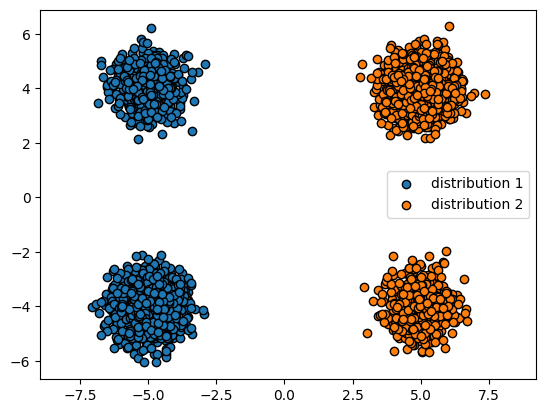

In [ ]:
# define data
import torch.distributions as td
from src.data import ToySampler

class TwoGaussians:
    def __init__(self, mus, props, sigmas):
        assert len(mus) == len(props) == len(sigmas)

        # build mu's and sigma's
        dim = len(mus[0])
        mus = [torch.Tensor(mu) for mu in mus]
        sigmas = [sigmas[i]*torch.eye(dim) for i in range(len(mus))]
        self.props = np.array(props) / sum(props)

        self.num = len(mus)
        self.dists=[
            td.multivariate_normal.MultivariateNormal(mu, sigma) for mu, sigma in zip(mus, sigmas)
        ]

    def sample(self, n):
        n = n[0]
        dist_idx = np.random.choice(self.num, n, p=self.props)
        dist_unique, dist_freq = np.unique(dist_idx, return_counts=True)
        samples = [self.dists[dist_unique_].sample([dist_freq_]) for dist_unique_, dist_freq_ in zip(dist_unique, dist_freq)]
        # samples=[dist.sample([int(ind_sample)]) for dist in self.dists]
        samples=torch.cat(samples,dim=0)
        return samples

dataset1 = TwoGaussians([[-5,4],[-5, -4]], [0.25, 0.75], [0.4, 0.4])
dataset2 = TwoGaussians([[5, 4], [5, -4]], [0.75, 0.25], [0.4, 0.4])
# dataset3 = TwoGaussians([[0, 9], [0, -9]], [0.5, 0.5], [0.4, 0.4])
sampler1 = ToySampler(dataset1)
sampler2 = ToySampler(dataset2)
# sampler3 = ToySampler(dataset3)

datas = [sampler1, sampler2]

def plot_initial_data(n):
    """
    mus - list of torch.Size([2])
    covs - list of torch.Size([2,2])
    n - int (amount of samples)
    """
    
    for idx,k in enumerate(range(CONFIG.K)):
        d = datas[k].sample([n])
        plt.scatter(d[:,0].cpu(),d[:,1].cpu(),edgecolor='black',label=f'distribution {idx+1}')
        plt.axis("equal")
        plt.grid()
        plt.legend()

plot_initial_data(2_000)

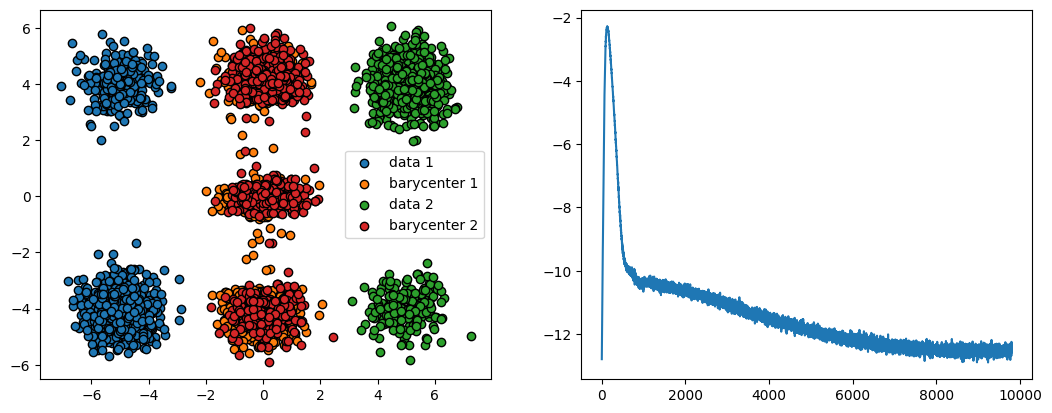

100%|██████████| 10000/10000 [04:07<00:00, 40.33it/s]


In [ ]:
def train(
    maps: OTMap, maps_opt, maps_sched, 
    pots: Pots, pots_opt, pots_sched,
    mvalue, mvalue_opt, mvalue_sched,
    reg_coeff: float = 0.0, tau: float = 1.0,
    divergence1: str = 'balanced',
    divergence2: str = 'balanced'
):
    divergences = [divergence1, divergence2]
    losses = []
    for epoch in tqdm(range(CONFIG.NUM_EPOCHS)):
        
        freeze(pots)
        freeze(mvalue)
        unfreeze(maps)
        
        #inner loop
        for it in range(CONFIG.INNER_ITERATIONS):
            for n in range(1):
                # data sampling
                data = [
                    datas[k].sample([CONFIG.BATCH_SIZE]).to(CONFIG.DEVICE)
                    for k in range(CONFIG.K)
                ]

                maps_opt.zero_grad()
                loss = 0
                for k in range(CONFIG.K):
                    mapped_x_k, reg = maps[k](data[k], reg=True)  # [B, N]
                    cost = strong_cost(data[k], mapped_x_k)  # [B, 1]
                    m = mvalue()
                    cost -= pots[k](mapped_x_k, m)  # [B, 1]
                    cost += reg_coeff * torch.unsqueeze(reg, -1)
                    cost = cost.mean(dim=0)
                    loss += CONFIG.LAMBDAS[k] * cost
                loss.backward()
                maps_opt.step()
                maps_sched.step()

        # unfreezing potentials 
        # freezing maps
        unfreeze(pots)
        unfreeze(mvalue)
        freeze(maps)
        
        # outer optimiztion
        pots_opt.zero_grad()
        mvalue_opt.zero_grad()
        loss=0

        m = mvalue()
        cost = None
        for k in range(CONFIG.K):
            mapped_x_k, reg = maps[k](data[k], reg=True)  # [B, N]
            
            cost = strong_cost(data[k], mapped_x_k)  # [B, 1]
            
            cost -= pots[k](mapped_x_k, m)  # [B, 1]
            if divergences[k] == 'kl':
                cost = - tau * (torch.exp(-cost/tau) - 1)
            elif divergences[k] == 'balanced':
                pass
            cost += m
            cost += reg_coeff * torch.unsqueeze(reg, -1)
            cost = cost.mean(dim=0)
            loss += CONFIG.LAMBDAS[k] * cost
        
        loss = -1*loss
        losses.append(loss.item())
        loss.backward()
        pots_opt.step()
        pots_sched.step()
        mvalue_opt.step()
        mvalue_sched.step()
        
        
        # plotting part
        if epoch % 200 ==0 :
            print(mvalue())
            data = [datas[k].sample([1_000]).to(CONFIG.DEVICE)
                        for k in range(CONFIG.K)]
            
            clear_output(wait=True)
            fig, (ax, ax_l) = plt.subplots(1, 2, figsize=(12.8, 4.8))
            for k in range(CONFIG.K):
                d = maps[k](data[k]).detach().cpu()
                ax.scatter(data[k][:,0].cpu(),data[k][:,1].cpu(),edgecolor='black',label=f'data {k+1}')
                ax.scatter(d[:,0],d[:,1],edgecolor='black',label=f'barycenter {k+1}')
                ax.grid()
                ax.legend()
                # ax.set_xlim(-8, 8)
                # ax.set_ylim(-8, 8)
                
            ax_l.plot(losses)
            plt.show()

seed_everything(0, avoid_benchmark_noise=True)


maps_ur = nn.ModuleList([
    DeterministicMap(CONFIG.INPUT_DIM, CONFIG.HIDDEN_DIMS, CONFIG.OUTPUT_DIM_MAP)
    for _ in range(CONFIG.K)
]).to(CONFIG.DEVICE)
maps_opt, maps_sched = get_opt_sched(maps_ur, CONFIG.LR, CONFIG.NUM_EPOCHS * CONFIG.INNER_ITERATIONS)

pots_ur = get_pots(CONFIG)
pots_opt, pots_sched = get_opt_sched(pots_ur, CONFIG.LR, CONFIG.NUM_EPOCHS)

# add m
mvalue = MinValue(CONFIG.DEVICE)
mvalue_opt = torch.optim.Adam(mvalue.parameters(), CONFIG.LR, (0.0, 0.9))
mvalue_sched = torch.optim.lr_scheduler.OneCycleLR(
        mvalue_opt,
        CONFIG.LR,
        total_steps=CONFIG.NUM_EPOCHS,
    )

train(maps_ur, maps_opt, maps_sched, pots_ur, pots_opt, pots_sched, mvalue, mvalue_opt, mvalue_sched, tau=Tau, divergence1=divergence, divergence2=divergence, divergence3=divergence)